<a href="https://colab.research.google.com/github/pedrowemanuel/redes-neurais-artificiais/blob/main/Usando_MLP_para_prever_complicacoes_de_infarto_do_miocardio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install ucimlrepo
from ucimlrepo import fetch_ucirepo
import torch
import matplotlib.pyplot as plt
import itertools
import numpy as np

# fetch dataset
myocardial_infarction_complications = fetch_ucirepo(id=579)

# data (as pandas dataframes)
X = myocardial_infarction_complications.data.features
y = myocardial_infarction_complications.data.targets

In [2]:
# data (as pandas dataframes)
X = myocardial_infarction_complications.data.features
y_all = myocardial_infarction_complications.data.targets
y = y_all[['ZSN']] # insuficiência cardíaca crônica

# remover colunas muitos dados faltantes: IBS_NASL(96%), S_AD_KBRIG(63%), D_AD_KBRIG(63%), KFK_BLOOD(100%), NA_KB(39%), NOT_NA_KB(40%), LID_KB(40%)
columns_remove = ['IBS_NASL', 'S_AD_KBRIG', 'D_AD_KBRIG', 'KFK_BLOOD', 'NA_KB', 'NOT_NA_KB', 'LID_KB']
X = X.drop(columns=columns_remove)

# Preencher os valores faltantes com a mediana de cada coluna
X = X.fillna(X.median())

X = X.values
y = y.values

# Converter arrays NumPy para tensores PyTorch
X = torch.tensor(X, dtype=torch.float32)  # Converte para tensor de ponto flutuante
y = torch.tensor(y, dtype=torch.long)  # Converte para tensor de inteiros longos para classificação

# Verificar o tamanho dos tensores
print('Tamanho de X tensor:', X.shape)
print('Tamanho de y tensor:', y.shape)

class Perceptron(torch.nn.Module):

    def __init__(self, n_inputs, n_outputs):
        super(Perceptron, self).__init__()
        # O Perceptron tem apenas uma camada linear (entrada -> saída)
        self.layer = torch.nn.Linear(n_inputs, n_outputs)

    def forward(self, x):
        # Passa pela única camada linear
        x = self.layer(x)
        # Aplica Sigmoid para binarização
        x = torch.sigmoid(x)  # Função de ativação sigmoid para classificação binária
        return x

class MLP(torch.nn.Module):

    def __init__(self, n_inputs, n_outputs, n_layers, n_hidden):
        super(MLP, self).__init__()
        self.n_layers = n_layers
        self.layers = torch.nn.ModuleList()
        for i in range(n_layers - 1):
            if i == 0:
                self.layers.append(torch.nn.Linear(n_inputs, n_hidden))
            else:
                self.layers.append(torch.nn.Linear(n_hidden, n_hidden))

        self.layers.append(torch.nn.Linear(n_hidden, n_outputs))


    def forward(self, x):
        for i in range(self.n_layers - 1):
            x = self.layers[i](x)
            x = torch.relu(x)
        x = self.layers[-1](x)
        x = torch.sigmoid(x)  # Aplica Sigmoid na última camada
        return x

# Embaralhar e dividir os dados (hold-out)

n_total = X.size(0)

# Definir proporções para cada subconjunto
n_test = int(0.2 * n_total)
n_val = int(0.2 * n_total)
n_train = n_total - n_test - n_val


Tamanho de X tensor: torch.Size([1700, 104])
Tamanho de y tensor: torch.Size([1700, 1])


In [3]:
# Listas para armazenar as acurácias
accuracy_mlp_list = []
accuracy_perceptron_list = []

num_runs = 10

for run in range(num_runs):
    print(f"===== Execução {run + 1} =====")

    # Embaralhar os dados
    indices = torch.randperm(n_total)
    X = X[indices]
    y = y[indices]

    # Dividir os dados
    X_train, X_val, X_test = torch.split(X, [n_train, n_val, n_test])
    y_train, y_val, y_test = torch.split(y, [n_train, n_val, n_test])

    # Verificar os tamanhos dos subconjuntos
    print('Tamanho de X_train:', X_train.shape)
    print('Tamanho de X_val:', X_val.shape)
    print('Tamanho de X_test:', X_test.shape)
    print('Tamanho de y_test:', y_test.shape)

    print('=========== TREINAMENTO ==========')
    model = MLP(n_inputs=104, n_outputs=1, n_layers=3, n_hidden=10)

    model.eval()
    with torch.no_grad():
        pred = model.forward(X_train)

    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0004)
    loss_fn = torch.nn.BCELoss()

    # Lista para armazenar o erro médio de cada época
    epoch_losses = []

    num_epochs = 50

    rows_train = X_train.shape[0]

    for j in range(num_epochs): #numero de epocas
        epoch_loss = 0  # Inicializa o erro da época

        for n in range(X_train.shape[0]):
            optimizer.zero_grad()

            # Predição do modelo
            y_hat = model(X_train[n])

            error = loss_fn(y_hat, y_train[n].float())  # loss (funcao de custo)

            # Propagação do erro
            error.backward()

            # Atualização dos parâmetros
            optimizer.step()

            # Acumular erro da amostra para calcular a média ao final da época
            epoch_loss += error.item()

        # Calcular o erro médio da época
        epoch_loss /= rows_train
        epoch_losses.append(epoch_loss)

    # # Plotar o gráfico do erro ao longo das épocas
    # plt.plot(range(1, num_epochs + 1), epoch_losses)
    # plt.xlabel('Épocas')
    # plt.ylabel('Erro Médio (Loss)')
    # plt.title('Loss ao Longo das Épocas')

    # spacing = 20  # Exibe um tick a cada 5 épocas
    # plt.xticks(range(1, num_epochs + 1, spacing))  # Define os ticks espaçados a cada 5 épocas

    # # Mostrar o gráfico
    # plt.show()

    model.eval()
    with torch.no_grad():
        pred = model(X_train)

    pred[pred > 0.5] = 1
    pred[pred < 0.5] = 0
    (pred == y_train).sum()/pred.shape[0]

    # modelo linear
    model_l = Perceptron(n_inputs=104, n_outputs=1)

    model_l.eval()
    with torch.no_grad():
        pred = model_l.forward(X_train)

    model_l.train()
    optimizer = torch.optim.Adam(model_l.parameters(), lr=0.0004)
    loss_fn = torch.nn.BCELoss()

    # Lista para armazenar o erro médio de cada época
    epoch_losses = []

    num_epochs = 50

    rows_train = X_train.shape[0]

    for j in range(num_epochs): #numero de epocas
        epoch_loss = 0  # Inicializa o erro da época

        for n in range(X_train.shape[0]):
            optimizer.zero_grad()

            # Predição do modelo
            y_hat = model_l(X_train[n])

            error = loss_fn(y_hat, y_train[n].float())  # loss (funcao de custo)

            # Propagação do erro
            error.backward()

            # Atualização dos parâmetros
            optimizer.step()

            # Acumular erro da amostra para calcular a média ao final da época
            epoch_loss += error.item()

        # Calcular o erro médio da época
        epoch_loss /= rows_train
        epoch_losses.append(epoch_loss)

    # # Plotar o gráfico do erro ao longo das épocas
    # plt.plot(range(1, num_epochs + 1), epoch_losses)
    # plt.xlabel('Épocas')
    # plt.ylabel('Erro Médio (Loss)')
    # plt.title('Loss ao Longo das Épocas')

    # spacing = 5  # Exibe um tick a cada 5 épocas
    # plt.xticks(range(1, num_epochs + 1, spacing))  # Define os ticks espaçados a cada 5 épocas

    # # Mostrar o gráfico
    # plt.show()

    model_l.eval()
    with torch.no_grad():
        pred_l = model_l(X_train)

    pred_l[pred_l > 0.5] = 1
    pred_l[pred_l < 0.5] = 0
    (pred_l == y_train).sum()/pred_l.shape[0]

    print('=========== VALIDACAO ==========')


    # ==================== validacao ====================
    def grid_search(X_train, y_train, X_val, y_val, n_inputs, n_outputs, n_layers_list, n_hidden_list, num_epochs=150, lr=0.0004):
        best_params = None
        best_accuracy = 0.0

        # Gerar todas as combinações de n_layers e n_hidden
        for n_layers, n_hidden in itertools.product(n_layers_list, n_hidden_list):
            print(f"Tentando n_layers={n_layers}, n_hidden={n_hidden}")

            # Inicializar o modelo
            model = MLP(n_inputs=n_inputs, n_outputs=n_outputs, n_layers=n_layers, n_hidden=n_hidden)
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)
            loss_fn = torch.nn.BCELoss()

            # Treinamento do modelo
            model.train()
            for epoch in range(num_epochs):
                optimizer.zero_grad()
                y_hat = model(X_train)
                error = loss_fn(y_hat, y_train.float())
                error.backward()
                optimizer.step()

            # Avaliar o modelo nos dados de validação
            model.eval()
            with torch.no_grad():
                pred = model(X_val)

            # Aplicar threshold para classificação
            pred[pred > 0.5] = 1
            pred[pred < 0.5] = 0

            # Calcular a acurácia
            accuracy = (pred == y_val).sum().item() / pred.shape[0]

            # Atualizar se a acurácia atual for a melhor
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_params = {'n_layers': n_layers, 'n_hidden': n_hidden}

        print(f"Melhores parâmetros: {best_params}, Melhor acurácia: {best_accuracy:.4f}")
        return best_params, best_accuracy


    # Parâmetros para a grid search
    n_layers = [2, 3, 4]
    n_hidden = [3, 5, 10, 20]

    # Chamar a grid search com os dados de treino e validação
    best_params, best_accuracy = grid_search(X_train, y_train, X_val, y_val, n_inputs=104, n_outputs=1,
                                            n_layers_list=n_layers, n_hidden_list=n_hidden)

    # usando o modelo escolhido
    print('==== usando o modelo escolhido grid_search ====')
    model = MLP(n_inputs=104, n_outputs=1, n_layers=best_params['n_layers'], n_hidden=best_params['n_hidden'])
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0004)
    loss_fn = torch.nn.BCELoss()

    num_epochs=20
    # Treinamento do modelo
    model.train()
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        y_hat = model(X_train)
        error = loss_fn(y_hat, y_train.float())
        error.backward()
        optimizer.step()



    print('========= TESTE ===========')
    # Avaliar o modelo nos dados de teste
    model.eval()
    with torch.no_grad():
        pred = model(X_test)

    # Aplicar threshold para classificação
    pred[pred > 0.5] = 1
    pred[pred < 0.5] = 0

    # Calcular a acurácia
    accuracy = (pred == y_test).sum().item() / pred.shape[0]

    accuracy_mlp_list.append(accuracy)

    print(f"Acurácia MLP: {accuracy:.4f}")

    # validacao perceptron

    model_l.eval()
    with torch.no_grad():
        pred_l = model_l(X_test)

    # Aplicar threshold para classificação
    pred_l[pred_l > 0.5] = 1
    pred_l[pred_l < 0.5] = 0

    # Calcular a acurácia
    accuracy_linear = (pred_l == y_test).sum().item() / pred_l.shape[0]
    accuracy_perceptron_list.append(accuracy_linear)

    print(f"Acurácia Perceptron: {accuracy_linear:.4f}")

# Calcular média e desvio padrão para as acurácias de MLP
mean_mlp = np.mean(accuracy_mlp_list)
std_mlp = np.std(accuracy_mlp_list)

# Calcular média e desvio padrão para as acurácias de Perceptron
mean_perceptron = np.mean(accuracy_perceptron_list)
std_perceptron = np.std(accuracy_perceptron_list)

# Exibir os resultados
print(f"\nResultados após {num_runs} execuções:")
print(f"Acurácia MLP: Média = {mean_mlp:.4f}, Desvio Padrão = {std_mlp:.4f}")
print(f"Acurácia Perceptron: Média = {mean_perceptron:.4f}, Desvio Padrão = {std_perceptron:.4f}")



===== Execução 1 =====
Tamanho de X_train: torch.Size([1020, 104])
Tamanho de X_val: torch.Size([340, 104])
Tamanho de X_test: torch.Size([340, 104])
Tamanho de y_test: torch.Size([340, 1])
=========== TREINAMENTO ==========
=========== VALIDACAO ==========
Tentando n_layers=2, n_hidden=3
Tentando n_layers=2, n_hidden=5
Tentando n_layers=2, n_hidden=10
Tentando n_layers=2, n_hidden=20
Tentando n_layers=3, n_hidden=3
Tentando n_layers=3, n_hidden=5
Tentando n_layers=3, n_hidden=10
Tentando n_layers=3, n_hidden=20
Tentando n_layers=4, n_hidden=3
Tentando n_layers=4, n_hidden=5
Tentando n_layers=4, n_hidden=10
Tentando n_layers=4, n_hidden=20
Melhores parâmetros: {'n_layers': 2, 'n_hidden': 3}, Melhor acurácia: 0.7647
==== usando o modelo escolhido grid_search ====
========= TESTE ===========
Acurácia MLP: 0.7706
Acurácia Perceptron: 0.7559
===== Execução 2 =====
Tamanho de X_train: torch.Size([1020, 104])
Tamanho de X_val: torch.Size([340, 104])
Tamanho de X_test: torch.Size([340, 104])


COMPARACAO PERCEPTRON x MLP

========= TESTE ===========


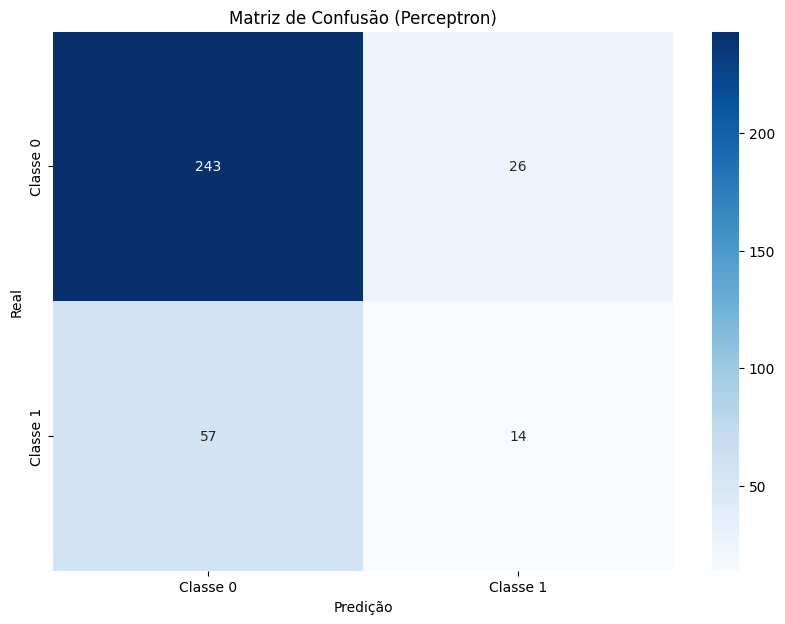

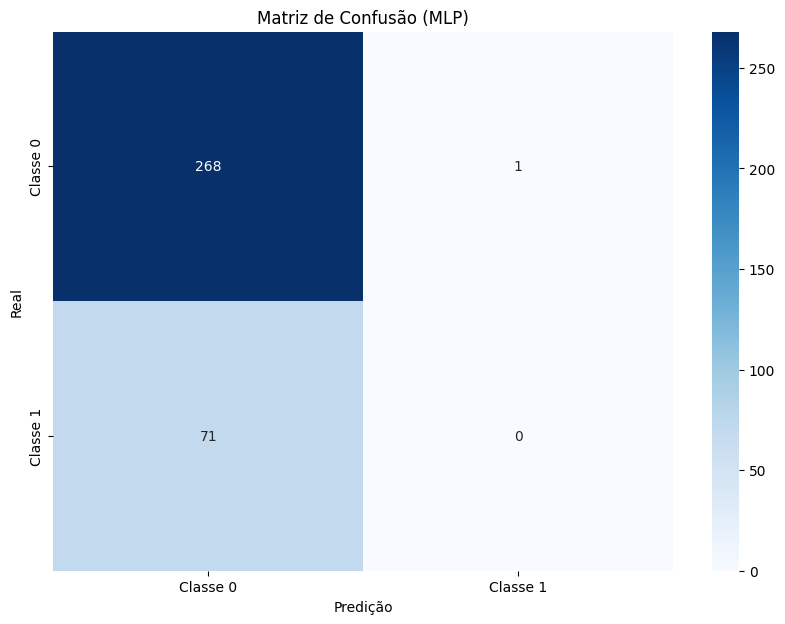

In [117]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

print('========= TESTE ===========')


# model_l.eval()
# with torch.no_grad():
#     pred_l = model_l(X_test)

# model.eval()
# with torch.no_grad():
#     pred = model(X_test)

# Supondo que pred_l e y_val sejam tensores PyTorch
pred_l_np = pred_l.numpy()
y_test_np = y_test.numpy()

# Converter previsões contínuas para binárias (0 ou 1)
pred_binary = (pred_l_np > 0.5).astype(int)

# Calcular a matriz de confusão
cm = confusion_matrix(y_test_np, pred_binary)

# Plotar a matriz de confusão
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Classe 0', 'Classe 1'],
            yticklabels=['Classe 0', 'Classe 1'])
plt.xlabel('Predição')
plt.ylabel('Real')
plt.title('Matriz de Confusão (Perceptron)')
plt.show()

# mlp
pred_np = pred.numpy()

# Converter previsões contínuas para binárias (0 ou 1)
pred_binary = (pred_np > 0.5).astype(int)

# Calcular a matriz de confusão
cm = confusion_matrix(y_test_np, pred_binary)

# Plotar a matriz de confusão
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Classe 0', 'Classe 1'],
            yticklabels=['Classe 0', 'Classe 1'])
plt.xlabel('Predição')
plt.ylabel('Real')
plt.title('Matriz de Confusão (MLP)')
plt.show()